In [1]:
import numpy as np 
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import Counter, OrderedDict
import copy 
import pandas as pd
import time
import datetime

import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
np.random.seed(7)

Using TensorFlow backend.


In [2]:
Dataset = r'../15minute_data_newyork/15minute_data_newyork.csv'
fulldata = pd.read_csv(Dataset) 

# Data Preprocessing

In [3]:
data=fulldata[['dataid','local_15min','grid']]
sorteddata=data.sort_values(by = ['dataid', 'local_15min'])
ids=sorteddata['dataid'].unique().tolist()

In [4]:
housing_data = []
def convertDate(d):
    d = pd.to_datetime(d[:-3])
    return d 

for i in range(len(ids)):
    housing_data.append(sorteddata.loc[sorteddata.dataid==ids[i]])
    housing_data[i] = housing_data[i].reset_index().drop(columns=['index'])
    housing_data[i]['local_15min'] = housing_data[i]['local_15min'].apply(convertDate)
    #Convert datetimes to ints for faster ploting 
    housing_data[i]['15min_ints'] =  housing_data[i]['local_15min'].map(mdates.date2num)

In [5]:
def create_dataset(dataset, look_back=1, look_ahead=None):
	"function for creating dataset for model, X being the known data, and Y being target data"
	if look_ahead is None:
		look_ahead = look_back
	dataX, dataY = [], []
	for i in range(len(dataset)-2*look_back):
		dataX.append(dataset[i:(i+look_back), 0])
		if look_ahead == 0:
			dataY.append(dataset[i + look_back, 0])
		else:
			dataY.append(dataset[(i+look_back):(i+look_back+look_ahead), 0])
		
	return np.array(dataX), np.array(dataY)


In [6]:
#set updataframe = housing_data[0]['grid']
dataframe = housing_data[0]['grid']
dataset = np.matrix(dataframe.values).transpose()
dataset = dataset.astype('float32')

In [7]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [8]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:,:]

In [9]:
# reshape into X=t and Y=t+look_back
look_back = 96 #(60mins/15min)*24 hours
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [10]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [11]:
model = load_model('../models/D_0house_model_1_25_adam.h5')
model.summary()


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dropout_50 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 96)                6240      
Total params: 23,136
Trainable params: 23,136
Non-trainable params: 0
_________________________________________________________________


# Data Analysis
## Average Day

In [12]:
time = housing_data[0]['local_15min']


In [13]:
#diff in time
print(time[0])
print(time[look_back])

2019-05-01 00:00:00
2019-05-02 00:00:00


In [14]:
fulldays=len(dataframe)//look_back
print(look_back*fulldays)

17568


In [15]:
grid_data=dataframe.to_numpy()

In [16]:
grid_data.shape

(17663,)

In [17]:
#convert to matrix
grid_day_matrix=grid_data[:(look_back*fulldays)].reshape(-1, 96)
#avg house0 grid data 
avg_house0_grid=np.mean(grid_day_matrix, axis=0)
grid_day_matrix.shape

(183, 96)

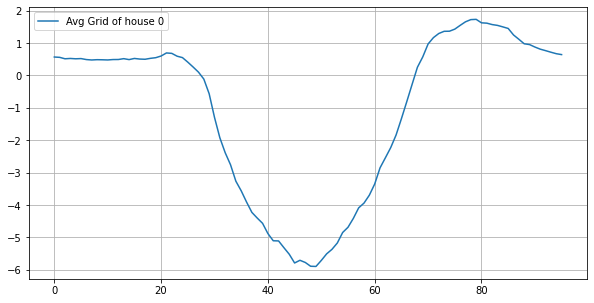

In [18]:
plt.figure(figsize=(10,5))
plt.plot(avg_house0_grid, label= 'Avg Grid of house 0' )
plt.grid(True)
plt.legend()

In [19]:
grid_day_matrix

array([[0.997, 0.75 , 0.608, ..., 0.219, 0.605, 0.304],
       [0.3  , 0.275, 0.296, ..., 0.409, 0.294, 0.26 ],
       [0.352, 0.355, 0.265, ..., 0.277, 0.361, 0.376],
       ...,
       [0.654, 0.512, 0.856, ..., 0.244, 0.155, 0.162],
       [0.315, 0.514, 0.429, ..., 0.238, 0.2  , 0.178],
       [0.217, 0.452, 0.43 , ..., 0.601, 0.551, 0.75 ]])

In [20]:
#predict on new housing data
house0X, house0Y = create_dataset(dataset, look_back)
house0X = house0X.reshape(house0X.shape[0], house0X.shape[1],1)
house0Predict = model.predict(house0X)

house0Predict = scaler.inverse_transform(house0Predict)
house0Y = scaler.inverse_transform(house0Y)


In [21]:
ttrain0Score = math.sqrt(mean_squared_error(house0Y, house0Predict))
print('Train Score: %.2f RMSE' % (ttrain0Score))


Train Score: 1.77 RMSE


In [22]:
house0Predict[::look_back]

array([[0.42874315, 0.3905604 , 0.28844008, ..., 1.2967987 , 1.214559  ,
        1.1457767 ],
       [0.24368382, 0.2659657 , 0.22332677, ..., 0.2980481 , 0.31262827,
        0.2763251 ],
       [0.32992408, 0.35608467, 0.29763645, ..., 0.34640476, 0.35295388,
        0.27326968],
       ...,
       [0.49467278, 0.6075746 , 0.61636394, ..., 0.19228101, 0.29056203,
        0.28807133],
       [0.45104128, 0.3699378 , 0.11540293, ..., 1.1096615 , 0.9274906 ,
        0.704601  ],
       [0.24014139, 0.2760538 , 0.20586629, ..., 0.61330044, 0.59082025,
        0.52454853]], dtype=float32)

In [23]:
pred_house0_matrix=house0Predict[::look_back]

In [24]:
pred_house0_grid=np.mean(pred_house0_matrix, axis=0)

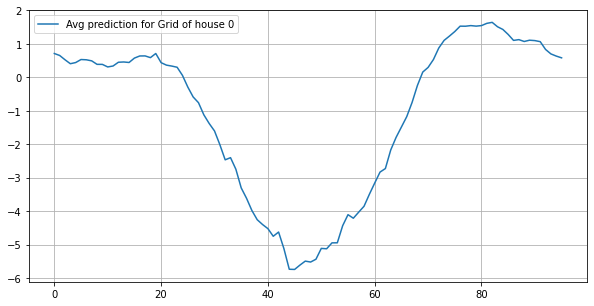

In [25]:
plt.figure(figsize=(10,5))
plt.plot(pred_house0_grid, label= 'Avg prediction for Grid of house 0' )
plt.grid(True)
plt.legend()

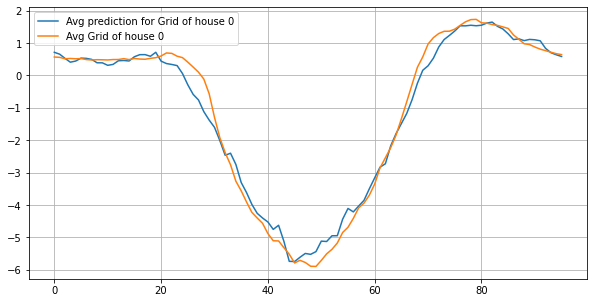

In [26]:
plt.figure(figsize=(10,5))
plt.plot(pred_house0_grid , label= 'Avg prediction for Grid of house 0')
plt.plot(avg_house0_grid, label= 'Avg Grid of house 0' )
plt.grid(True)
plt.legend()

In [27]:
ttrain0Score = math.sqrt(mean_squared_error(pred_house0_grid, avg_house0_grid))
print('Train Score: %.2f RMSE' % (ttrain0Score))

Train Score: 0.32 RMSE


## Error of model 

In [28]:
abs_error = abs(avg_house0_grid-pred_house0_grid)
error = avg_house0_grid-pred_house0_grid
# error = pred_house0_grid-avg_house0_grid

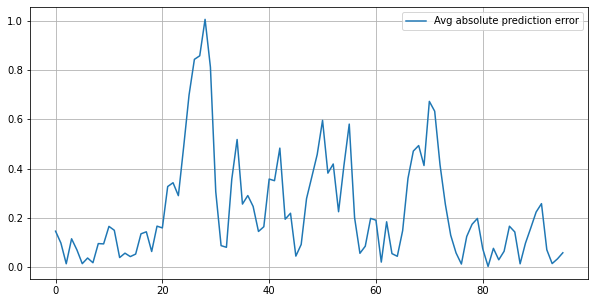

In [29]:
plt.figure(figsize=(10,5))
plt.plot(abs_error, label= 'Avg absolute prediction error')
plt.grid(True)
plt.legend()

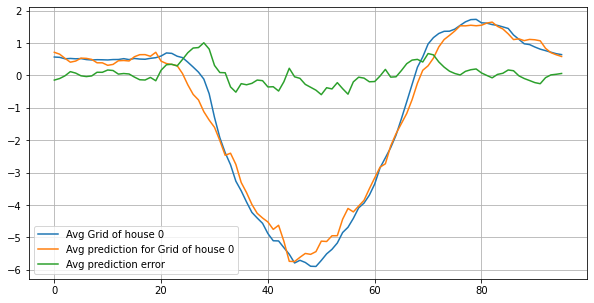

In [30]:
plt.figure(figsize=(10,5))
plt.plot(avg_house0_grid, label= 'Avg Grid of house 0' )
plt.plot(pred_house0_grid, label= 'Avg prediction for Grid of house 0' )
plt.plot(error, label= 'Avg prediction error')
plt.legend()
plt.grid(True)


In [31]:
f_h=pred_house0_grid/avg_house0_grid
f_h = np.mean(f_h)
100-f_h*100


10.01835939913768

## Uncertainty of model 
https://fairyonice.github.io/Measure-the-uncertainty-in-deep-learning-models-using-dropout.html

In [32]:
#Set up X 
uncertaintlytestX=house0X[::look_back]
uncertaintlytestX.shape

(182, 96, 1)

In [33]:
house0Y.shape

(17471, 96)

In [34]:
class KerasDropoutPrediction(object):
    def __init__(self,model):
        self.f = K.function(
                [model.layers[0].input, 
                 K.learning_phase()],
                [model.layers[-1].output])
    def predict(self,x, n_iter=10):
        result = []
        for _ in range(n_iter):
            buf=self.f([x , 1])
            # print(np.asarray(buf).shape)
            result.append(buf)
        result = np.array(result).reshape(n_iter,len(x),96).T
        return result
Nsim = look_back*10
kdp = KerasDropoutPrediction(model)
result = kdp.predict(uncertaintlytestX, Nsim)

In [35]:
result.shape

(96, 182, 960)

In [36]:
maxypredict = np.amax(result,axis=2)
maxypredict=scaler.inverse_transform(maxypredict)
minypredict = np.amin(result,axis=2)
minypredict=scaler.inverse_transform(minypredict)

In [37]:
maxy_avg_predict = np.mean(maxypredict, axis = 1)
miny_avg_predict = np.mean(minypredict, axis = 1)

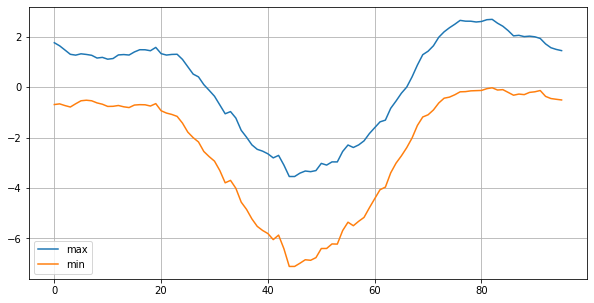

In [38]:
plt.figure(figsize=(10,5))
plt.plot(maxy_avg_predict, label='max')
plt.plot(miny_avg_predict, label='min')
plt.grid(True)
plt.legend()

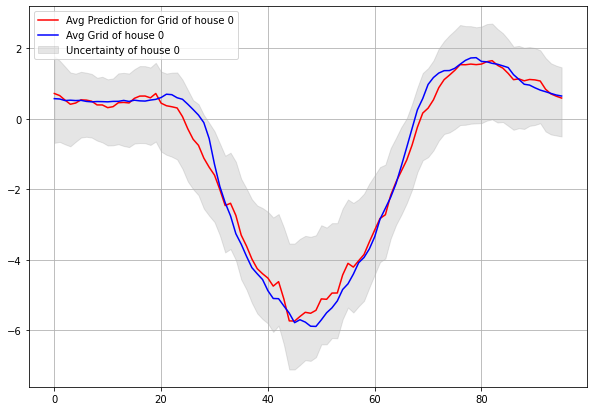

In [39]:
x = np.arange(96)
plt.figure(figsize=(10,7))
plt.plot(x, pred_house0_grid, 'r', label='Avg Prediction for Grid of house 0' )
plt.plot(avg_house0_grid, 'b', label='Avg Grid of house 0')
plt.fill_between(x, miny_avg_predict,maxy_avg_predict, color='gray', alpha=0.2, label='Uncertainty of house 0')
plt.grid(True)
plt.legend()